# Physics-Informed Neural Network: Solving a Family of Wave Equations

This notebook implements a **physics-informed neural network (PINN)** for solving a **family of one-dimensional wave equations** with varying initial conditions. The approach is inspired by the technics given in:

> *Raissi et al., 2019 – Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations.*

### Original Contribution

We use the PINN framework to develop a **general solution method for a family of PDEs**.

The neural network is trained to infer the solution $u(x, t)$ of the wave equation, **given the Fourier coefficients of the initial condition**. This allows the model to generalize across a family of problems with varying Dirichlet boundary conditions.

In other words, the network approximates a **solution operator** that maps a compact Fourier representation of the initial condition to the corresponding PDE solution, enabling flexible inference across a parameterized family of wave equations.



## Problem Setup

We consider the one-dimensional wave equation:

$$
\frac{\partial^2 u}{\partial t^2}(x, t) = \frac{\partial^2 u}{\partial x^2}(x, t), \quad x \in [0, 1],\ t \in [0, 1],
$$

subject to the following **initial and boundary conditions**:

- Initial displacement:
  $$
  u(x, 0) = g(x)
  $$
- Initial velocity:
  $$
  \frac{\partial u}{\partial t}(x, 0) = 0
  $$
- Boundary conditions:
  $$
  u(0, t) = u(1, t) = 0
  $$

Our objective is to approximate the solution $u(x, t)$ for different initial displacements $g(x)$ using a PINN.  
The initial displacement is represented as a smooth function given by a truncated Fourier sine series:

$$
g(x) = \sum_{n=1}^{N_A} A_n \sin(n\pi x),
$$

where the coefficients $A_1, \dots, A_{N_A}$ parameterize a family of initial conditions.

The PINN takes as input the spatial and temporal coordinates, along with the Fourier coefficients, and outputs the predicted displacement:

$$
\text{NN}(x, t, A_1, \dots, A_{N_A}) \longrightarrow u(x, t)
$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import integrate
from time import time
from tqdm import tqdm

# Initialization: Data Types, Constants, and GPU Check


In [ ]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)
# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)

## check if GPU is available
print("TF is built with coda = " + str(tf.test.is_built_with_cuda()))
print("GPU = " + str(tf.config.list_physical_devices('GPU')))
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
   details = tf.config.experimental.get_device_details(gpu_devices[0])
   details.get('device_name', 'Unknown GPU')
   print(str(details))

# Set random seed for reproducible results
tf.random.set_seed(0)

TF is built with coda = True
GPU = [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
{'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


### Model and Training Configuration

In [ ]:
layers = 4
neurons = 100

N_0 = 100  # Number of testing points for x
N_A = 100  # Number of training points for initial condition parameters
num_epochs = 100
num_lambda = 3  # Number of Fourier coefficients

N_collocation = 6000
N_boundary = 600
N_initial = 600

omega = 0.3  # Loss weighting: PDE vs data
Amax = 0.65
Amin = -0.51

tmin = 0.0
tmax = 1.0
xmin = 0.0
xmax = 1.0

### Problem Parameters and Initial Condition Functions

The following functions define the exact initial condition $g(x)$ and the corresponding analytical solution using a truncated Fourier sine series.

In [ ]:
def fourier_sine_coefficients(f, n_max=3):
    """
    Computes the first n_max sine Fourier coefficients A_n for the function f on [0, 1],
    using the formula:
        A_n = 2 * ∫₀¹ f(x) * sin(nπx) dx

    Parameters:
        f : function
            The input function f(x), defined on [0, 1].
        n_max : int
            Number of sine coefficients to compute.

    Returns:
        list of float : The Fourier sine coefficients A_1 to A_n_max.
    """
    coefficients = []

    for n in range(1, n_max + 1):
        integrand = lambda x: f(x) * np.sin(n * np.pi * x)
        result, _ = integrate.quad(integrand, 0, 1)
        coefficients.append(2 * result)

    return coefficients

def u_0(x, A):
    u_ini = 0
    for i in range(num_lambda):
        u_ini += A[:, i:(i+1)] * tf.sin((i + 1) * np.pi * x)
    return u_ini

def fun_u_b():
    return tf.zeros((N_boundary,1), dtype=DTYPE)

### Sampling Collocation, Boundary, and Initial Points

In [ ]:
# Set collocation points
X = tf.random.uniform((N_collocation,1), xmin, xmax, dtype=DTYPE)
T = tf.random.uniform((N_collocation,1), tmin, tmax, dtype=DTYPE)
A = tf.random.uniform((N_collocation,num_lambda), Amin, Amax, dtype=DTYPE)
XTA_collocation = tf.concat([X, T, A], axis=1)

# Set left boundary points
X = tf.cast(tf.expand_dims(tf.transpose(tf.ones(N_boundary)*xmin),axis=1), tf.float32) # x=xmin vector N0 X 1
T = tf.random.uniform((N_boundary,1), tmin, tmax, dtype=DTYPE)
A = tf.random.uniform((N_boundary,num_lambda), Amin, Amax, dtype=DTYPE)
XTA_BND_Left = tf.concat([X, T, A], axis=1)

# Set the right boundary points
X = tf.cast(tf.expand_dims(tf.transpose(tf.ones(N_boundary)*xmax),axis=1), tf.float32) # x=xmin vector N0 X 1
T = tf.random.uniform((N_boundary,1), tmin, tmax, dtype=DTYPE)
A = tf.random.uniform((N_boundary,num_lambda), Amin, Amax, dtype=DTYPE)
XTA_BND_Right = tf.concat([X, T, A], axis=1)

# Set points for the initial condition
X = tf.random.uniform((N_initial,1), xmin, xmax, dtype=DTYPE)
T = tf.cast(tf.expand_dims(tf.transpose(tf.ones(N_initial)*tmin),axis=1), tf.float32) # x=xmin vector N0 X 1
A = tf.random.uniform((N_initial,num_lambda), Amin, Amax, dtype=DTYPE)
XTA_INI = tf.concat([X, T, A], axis=1)


## Analytical Solution: Real Solution via Fourier Series

The 1D wave equation with zero initial velocity and sine series initial displacement:

$$
u(x, 0) = \sum_{n=1}^{N} A_n \sin(n\pi x), \quad \frac{\partial u}{\partial t}(x, 0) = 0
$$

has the analytical solution:

$$
u(x, t) = \sum_{n=1}^{N} A_n \cos(n\pi t) \sin(n\pi x)
$$

We use this expression to compute the reference (ground truth) solution for evaluating the accuracy of the PINN predictions.

In [ ]:
def real_solution(A, x, t):
    res = 0
    for i in range(len(A)):
        res += A[i] * np.cos((i + 1) * pi * t) * np.sin((i + 1) * pi * x)
    return res

### Neural Network Architecture

In [ ]:
layers = 4
neurons = 100
num_epochs = 10000


NN = tf.keras.Sequential()
NN.add(tf.keras.Input((2 + num_lambda,)))  # input is x,t,A

# Append hidden layers
tanh = tf.keras.activations.get('tanh')

for _ in range(layers):
  NN.add(tf.keras.layers.Dense( neurons , activation=tanh ,kernel_initializer='glorot_normal'))

# Output is one-dimensional:
NN.add(tf.keras.layers.Dense(1))

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,20000],[1e-3,9e-4,1e-4])
optim = tf.keras.optimizers.Adam(learning_rate=lr)

### Loss Function
$$MSE=\omega\cdot MSE_{collocation}+\left(1-\omega\right)\left(MSE_{initial}+MSE_{boudary}\right) $$

where $\omega =1/3$ and:
- **MSE for PDE residual**: $u_{tt} - u_{xx}$ at collocation points
$$
MSE_{collocation}=\frac{1}{N_{c}}\sum_{i=1}^{N_{c}}\left|NN_{tt}\left(t_{i}^{c},x_{i}^{c},A_{1,i}^{c},...,A_{N_{A},i}^{c}\right)-NN_{xx}\left(t_{i}^{c},x_{i}^{c},A_{1,i}^{c},...,A_{N_{A},i}^{c}\right)\right|^{2}
$$
- **MSE for initial condition**
$$
MSE_{initial}=\frac{1}{N_{int}}\sum_{i=1}^{N_{int}}\left|NN\left(0,x_{i}^{int},A_{1,i}^{int},...,A_{N_{A},i}^{int}\right)-\sum_{n=0}^{N_{A}}A_{n}\sin\left(n\pi x\right)\right|^{2}
$$
- **MSE for boundary condition**
$$
MSE_{boundary}=\frac{1}{N_{b}}\sum_{i=1}^{N_{b}}\left(\left|NN\left(t_{i}^{b},0,A_{1,i}^{b},...,A_{N_{A},i}^{b}\right)\right|^{2}+\left|NN\left(t_{i}^{b},1,,A_{1,i}^{b},...,A_{N_{A},i}^{b}\right)\right|^{2}\right)
$$


In [ ]:
def compute_loss_pde(XTA_collocation):
    x = XTA_collocation[:, 0:1]
    t = XTA_collocation[:, 1:2]
    A = XTA_collocation[:, 2:2+num_lambda]
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch(x)
            tape2.watch(t)
            XTA_input = tf.concat([tf.stack([x[:,0],t[:,0]], axis=1),A],axis=1)
            output = NN(XTA_input)
        N_x = tape.gradient(output, x)
        N_t = tape.gradient(output, t)
        del tape2
    N_xx = tape.gradient(N_x, x)
    N_tt = tape.gradient(N_t, t)
    MSEc = tf.reduce_mean(tf.square(N_tt - N_xx))
    del tape
    return MSEc

def compute_loss(XTA_collocation, XTA_BND_Left, XTA_BND_Right,XTA_INI):
    with tf.device('/GPU:1'):


        MSE_c = compute_loss_pde(XTA_collocation)


        u_pred_left = NN(XTA_BND_Left)
        u_pred_right = NN(XTA_BND_Right)

        MSE_b = tf.reduce_mean(tf.square(u_pred_left)) + tf.reduce_mean(tf.square(u_pred_right))



        x = XTA_INI[:, 0:1]
        A = XTA_INI[:, 2:2+num_lambda]


        u_pred = NN(XTA_INI)
        loss_u_ini = tf.reduce_mean(tf.square(u_0(x,A) - u_pred))

        lost_iter_bnd = ( MSE_b + loss_u_ini )


        loss = omega * MSE_c + (1-omega) * lost_iter_bnd


    return loss, MSE_c, lost_iter_bnd

### Training the Network

Iteration 10000: loss =  3.638e-03: 100%|██████████| 10000/10000 [24:27<00:00,  6.81it/s]



Computation time: 1467.46 seconds


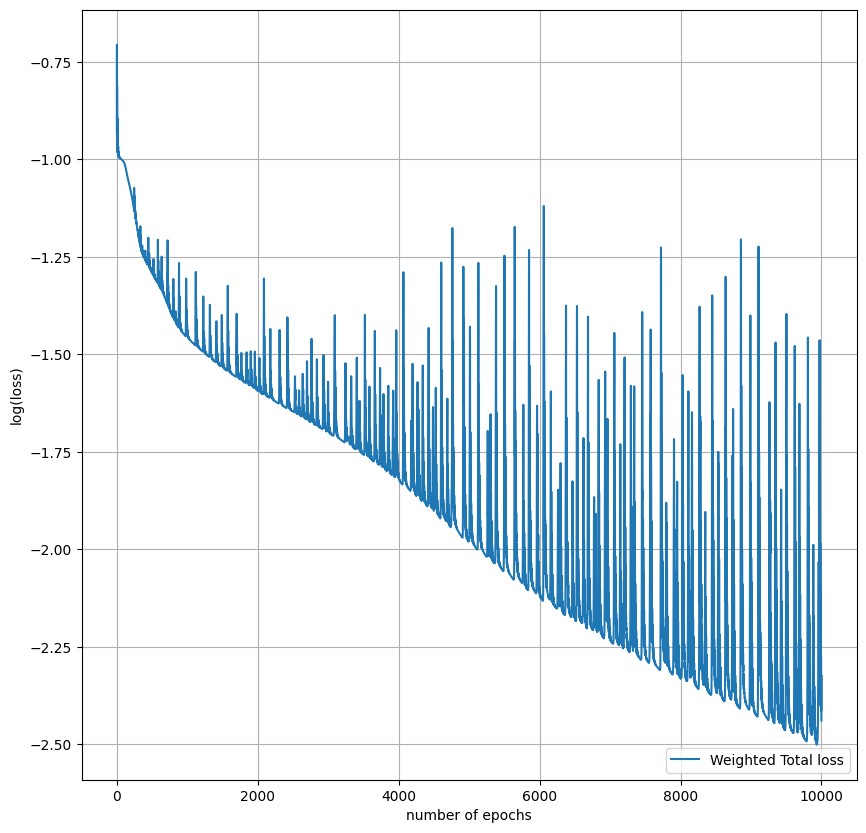

In [ ]:
tf.config.run_functions_eagerly(True)

def get_grad(XT_collocation, XT_BND_Left, XT_BND_Right,XT_INI):
    with tf.device('/GPU:0'):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with respect to trainable variables
            # tape.watch(NN.trainable_variables)
            loss, loss_iter_pde, loss_iter_bnd = compute_loss(XT_collocation, XT_BND_Left, XT_BND_Right,XT_INI)
        grad = tape.gradient(loss, NN.trainable_variables)
        del tape
    return loss, loss_iter_pde, loss_iter_bnd, grad


@tf.function
def train_step():
    with tf.device('/GPU:0'):
        loss, loss_iter_pde, loss_iter_bnd, grad_theta = get_grad(XTA_collocation, XTA_BND_Left, XTA_BND_Right, XTA_INI)
        optim.apply_gradients(zip(grad_theta, NN.trainable_variables))
    return loss_iter_pde, loss_iter_bnd

hist_pde = []
hist_boundary = []

t0 = time()
pbar = tqdm(range(num_epochs))
for i in pbar:
    loss_iter_pde, loss_iter_bnd = train_step()
    current_iteration = i + 1
    loss = omega * loss_iter_pde + (1 - omega) * loss_iter_bnd

    hist_pde.append(loss_iter_pde.numpy())
    hist_boundary.append(loss_iter_bnd.numpy())

    if current_iteration % 50 == 0:
        pbar.set_description('Iteration {:05d}: loss = {:10.3e}'.format(current_iteration, loss))

print('\nComputation time: {:.2f} seconds'.format(time() - t0))

fig3 = plt.figure(figsize=(10,10))
x_axis = np.linspace(1,num_epochs,num_epochs)
#plt.plot(x_axis, np.log10(hist_pde), label='PDE loss')
#plt.plot(x_axis, np.log10(hist_boundary), label='BND loss')
total_loss = np.add(np.multiply(omega,hist_pde),np.multiply(1-omega, hist_boundary))
plt.plot(x_axis, np.log10(total_loss), label='Weighted Total loss')
plt.ylabel("log(loss)", fontsize=10)
plt.xlabel("number of epochs", fontsize=10)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True)
plt.show()

## Results and Evaluation

We evaluate the trained PINN on a specific initial condition:

$$
g(x) \approx 6(x - x^3)\left(x - \tfrac{1}{4}\right).
$$

This function is approximated using only three Fourier sine coefficients. While the coefficients decay rapidly, achieving higher-order accuracy requires training a larger network with more parameters.

The true solution is computed using the Fourier series method. We compare the PINN-predicted solution against the analytical solution at multiple time instances, and report the relative $L^2$ error.

We visualize the results at four selected time points:

- $t = 0$
- $t = \tfrac{1}{3}$
- $t = \tfrac{1}{2}$
- $t \approx 1$

Each subplot shows the predicted solution $u_{NN}(x, t)$ compared with the ground truth $u(x, t)$, obtained using the analytical solution.
We also report the relative $L^2$ error between the predicted and true solutions at each time instance.


time = 0.00
Relative L2 Error = 2.80e+03
time = 0.33
Relative L2 Error = 1.29e+03
time = 0.50
Relative L2 Error = 2.19e+03
time = 0.99
Relative L2 Error = 2.69e+03


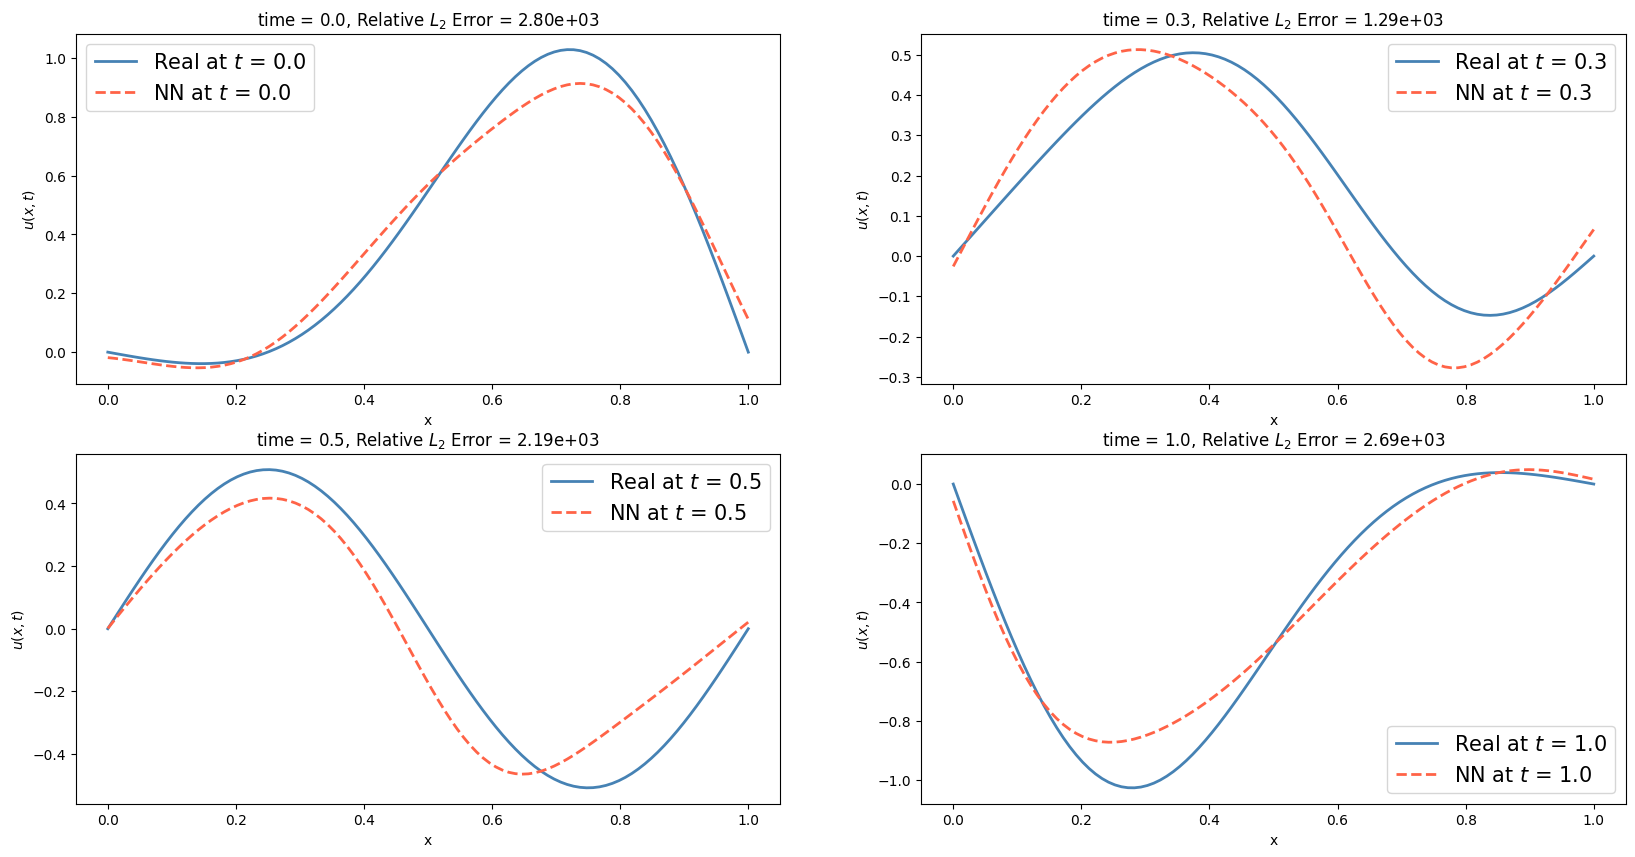

In [ ]:
# Define g(x) and calculate its coefficients
g = lambda x: 6 * (x - x**3) * (x - 1/4)
Alist = fourier_sine_coefficients(g,n_max=num_lambda)

# print('Make sure all A_i is in [-1/2,1/2]: ' + str(fourier_sine_coefficients(f,n_max=num_lambda)))

X = tf.transpose(tf.expand_dims(tf.linspace(xmin,xmax,N_0),axis=0))

for i in range(1,num_lambda+1):
    tmp_vec = tf.ones(shape=(N_0,1)) * Alist[i-1] # 4 columns with all A_vec[i] at the i'th column
    if i == 1:
        A = tmp_vec
    else:
        A = tf.concat([A,tmp_vec],axis=1)

# Select time points to plotting velocity vs position
dt = 0.01
timepoints = np.array([0, tmax / 3, tmax / 2, tmax / 1.01])
timepoints_idx = timepoints / dt

# Plot velocity vs position for 6 different time points
fig1, ax1 = plt.subplots(2,2, figsize=(20, 10))
plot_num = 0
for i in range(0,2):
      for j in range(0,2):

        t0 = timepoints[plot_num]
        T = np.full((N_0,1), t0 )

        XTA_collocation = tf.concat([X, T, A], axis=1)
        u_NN = NN(XTA_collocation)

        idx = int(timepoints_idx[plot_num])
        u_real = real_solution(Alist, np.squeeze(X), np.squeeze(T))


        time_str = '{0:.1f}'.format(t0)

        ax1[i,j].plot(X, u_real, color='steelblue',linewidth=2 ,label=f'Real at $t$ = ' + time_str)
        ax1[i,j].plot(X, u_NN , color='tomato',linewidth=2 , linestyle = '--', label=f'NN at $t$ = ' + time_str )

        print('time = {0:.2f}'.format(t0))

        E = np.sum((u_NN - u_real)**2)

        relE =  np.sqrt( E / np.sum(u_real**2))
        print("Relative L2 Error = " + str("{:.2e}".format(E)) )
        ax1[i,j].title.set_text("time = {:.1f}, Relative $L_2$ Error = {:.2e}".format(t0,E))

        # Add labels
        ax1[i,j].set_xlabel('x')
        ax1[i,j].set_ylabel(f'$u(x,t)$')
        ax1[i,j].legend(fontsize = 15)

        plot_num += 1

        if plot_num == 4:
            plt.show()

### Conclusion
This experiment demonstrates that PINNs can generalize to a **family of PDE problems** by learning the solution as a function of both space-time and a set of initial condition parameters. The approach shows promise in data-scarce regimes and highlights how machine learning and classical PDE solving can complement one another.